In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Probabilitas algoritma X > Y, maka S ( y < x => 1, y = x => 0.5, y > x => 0)
def S(x, y):
    if y > x:
        return 1
    elif x == y:
        return 0.5
    else:
        return 0
    
def probability_of_improvement(x_scores, y_scores):
    # Menilai apakah Y apakah lebih baik dari X
    N = len(x_scores)  # Jumlah percobaan untuk X
    K = len(y_scores)  # Jumlah percobaan untuk Y
    
    total_sum = 0
    for i in range(N):
        for j in range(K):
            total_sum += S(x_scores.iloc[i], y_scores.iloc[j])
    
    # Probability of improvement
    return total_sum / (N * K)

Import dataset pelatihan

In [52]:
dataframe_training = pd.read_csv("UNREAL-training/UNREAL-lines.csv")
dataframe_training_5M = pd.read_csv("UNREAL-training/UNREAL-cont-lines.csv")
dataframe_training = (
    dataframe_training
    .fillna(0)
    .drop(columns=["Wall time"])
    .rename(columns=
        {
            "Step": "step",
            "Value": "value",
        }
    )
)
dataframe_training.head()

,step,value
0,40014,16.0
1,40016,16.0
2,40033,16.0
3,40037,16.0
4,40057,16.0


Plot total lines cleared

Text(0.5, 0, 'Episode')

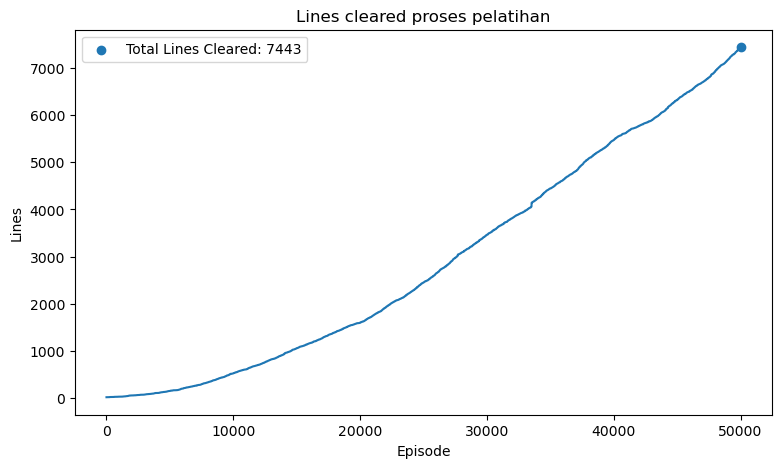

In [253]:
plt.figure(figsize=(9, 5))
# Menambahkan titik scatter di ujung plot (nilai maksimum)
max_value = dataframe_training["value"].max()
max_index = dataframe_training["value"].idxmax()  # Indeks dari nilai maksimum

# Scatter plot pada titik maksimum
plt.scatter(max_index, max_value, label=f'Max Value: {max_value}', zorder=5)
dataframe_training["value"].plot(kind='line')
plt.legend(loc='upper left', labels=[f'Total Lines Cleared: {int(max_value)}'])
plt.title("Lines cleared proses pelatihan")
plt.ylabel("Lines")
plt.xlabel("Episode")

Import dataset pelatihan - block

In [261]:
dataframe_training_blocks_25M = pd.read_csv("UNREAL-training/UNREAL-w-blocks.csv").iloc[::5]
dataframe_training_blocks = (
    dataframe_training_blocks_25M
    .fillna(0)
    .drop(columns=["Wall time"])
    .rename(columns=
        {
            "Step": "step",
            "Value": "value",
            # "UNREAL - game/Block placed": "blocks",
            # "UNREAL - game/Block placed__MIN": "min blocks",
            # "UNREAL - game/Block placed__MAX": "max blocks",
        }
    )
)
dataframe_training_blocks['smoothed'] = dataframe_training_blocks['value'].rolling(window=25).mean()
dataframe_training_blocks.head()

,step,value,smoothed
0,40042,20.0,NaN
5,40402,18.0,NaN
10,40716,18.0,NaN
15,41033,14.0,NaN
20,41332,17.0,NaN


Visualisasi moving average blok pelatihan

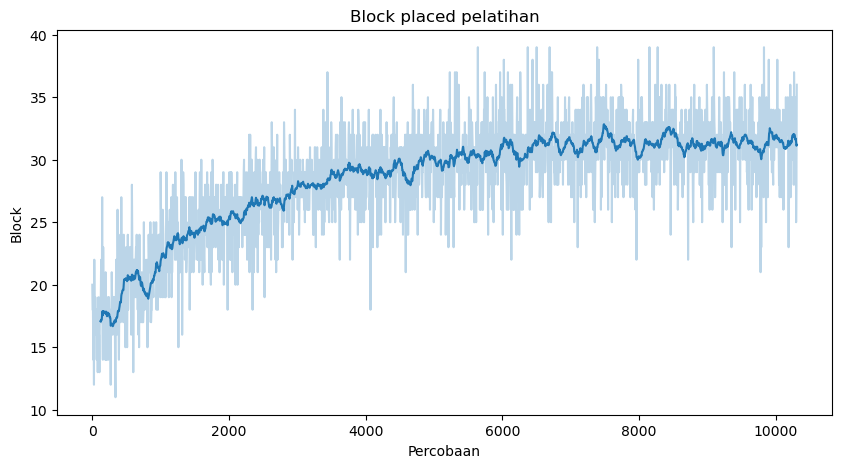

In [262]:
dataframe_training_blocks.value.plot(color='tab:blue', alpha=0.3, figsize=(10, 5))
dataframe_training_blocks.smoothed.plot(color='tab:blue', figsize=(10, 5))

plt.title("Block placed pelatihan")
plt.xlabel("Percobaan")
plt.ylabel("Block")
plt.show()

Menghitung POI setiap 20% data

In [263]:
data_portion = []
n_data = len(dataframe_training_blocks)
for i in range(5):
    start = int(n_data * ( i * .2 ))
    stop = int(n_data * ((i + 1) * .2))
    data_portion.append(dataframe_training_blocks.iloc[start:stop])

In [264]:
probability_of_improvement_res = {}
alpha = 0.05
for i in range(len(data_portion)):
    stats = []
    for sample in range(2000):
        x_scores = data_portion[i]["value"].sample(n=30, replace=True)  # baseline
        y_scores = data_portion[-1]["value"].sample(n=30, replace=True)  #
        # Menilai peluang peningkatan apakah 25% data terakhir meningkatkan kinerja
        POI = probability_of_improvement(x_scores, y_scores)
        stats.append(POI)

    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))

    probability_of_improvement_res[f"{25 * .2 * (i + 1)}M vs 25M"] = {
        "POI": stats,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "mean": np.mean(stats),
        "std": np.std(stats),
    }

print(probability_of_improvement_res)

{'5.0M vs 25M': {'POI': [0.9722222222222222, 0.9705555555555555, 0.9777777777777777, 0.9883333333333333, 0.9638888888888889, 0.99, 0.9527777777777777, 0.9944444444444445, 0.9666666666666667, 0.9833333333333333, 0.9777777777777777, 0.9888888888888889, 0.9944444444444445, 0.9811111111111112, 0.9822222222222222, 0.9638888888888889, 0.9616666666666667, 0.9677777777777777, 0.9777777777777777, 0.9672222222222222, 0.9605555555555556, 0.9694444444444444, 0.9811111111111112, 0.9927777777777778, 0.9905555555555555, 0.9677777777777777, 0.9483333333333334, 0.9916666666666667, 0.9483333333333334, 0.9977777777777778, 0.9594444444444444, 0.97, 0.9611111111111111, 0.9905555555555555, 0.9583333333333334, 0.9761111111111112, 0.9777777777777777, 0.9977777777777778, 0.9933333333333333, 0.9877777777777778, 0.9655555555555555, 0.9983333333333333, 0.9477777777777778, 0.9861111111111112, 0.9905555555555555, 0.9783333333333334, 0.9672222222222222, 0.9955555555555555, 0.9594444444444444, 0.9905555555555555, 0.9

In [265]:
df_poi = pd.DataFrame(probability_of_improvement_res).transpose()[:-1]
df_poi.head()

,POI,lower_bound,upper_bound,mean,std
5.0M vs 25M,"[0.9722222222222222, 0.9705555555555555, 0.977...",0.939431,0.998889,0.976881,0.015734
10.0M vs 25M,"[0.8911111111111111, 0.8455555555555555, 0.886...",0.72,0.925014,0.830364,0.052633
15.0M vs 25M,"[0.5722222222222222, 0.6544444444444445, 0.688...",0.517222,0.787222,0.653409,0.069741
20.0M vs 25M,"[0.42444444444444446, 0.44166666666666665, 0.4...",0.387778,0.677819,0.530829,0.07498


Visualisasi CI

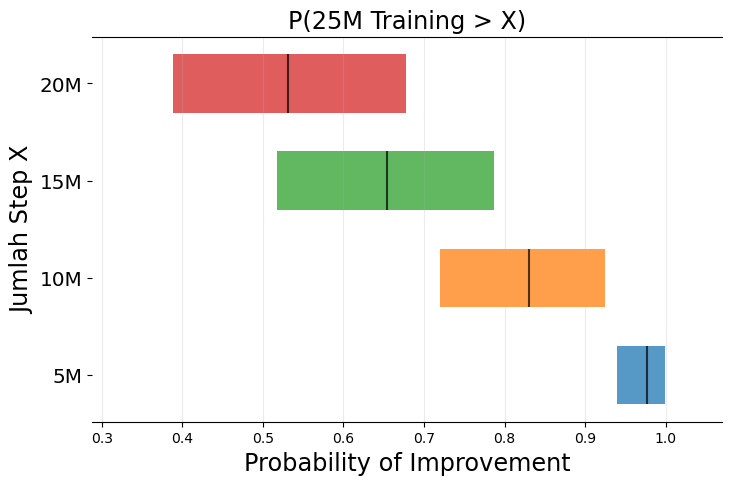

In [285]:
plt.figure(figsize=(7, 5))

# Plot interval kepercayaan dan mean
for idx in range(len(df_poi['POI'])):
    lower = df_poi.iloc[idx, 1]
    upper = df_poi.iloc[idx, 2]
    mean = df_poi.iloc[idx, 3]
    
    # Plotkan interval (bar horizontal)
    plt.barh(y=idx, width=upper - lower, left=lower, height=0.6, alpha=0.75)
    
    # Plotkan mean (garis vertikal)
    plt.vlines(x=mean, ymin=idx - 0.3, ymax=idx + 0.3, color='k', alpha=0.7)

# Mengatur label dan tampilan sumbu
plt.yticks(range(len(df_poi['POI'])), ["20M", "15M", "10M", "5M"][::-1], fontsize='x-large')
plt.xlabel("Probability of Improvement", fontsize='xx-large')
plt.ylabel("Jumlah Step X", fontsize='xx-large')
plt.xlim(df_poi["lower_bound"].min() - 0.1, 1.07)

# Mengatur grid dan spines
plt.grid(True, axis='x', alpha=0.25)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Menambahkan judul
plt.title("P(25M Training > X)", fontsize='xx-large')

plt.subplots_adjust(wspace=0.12, hspace=0.05, left=0.0)
plt.show()